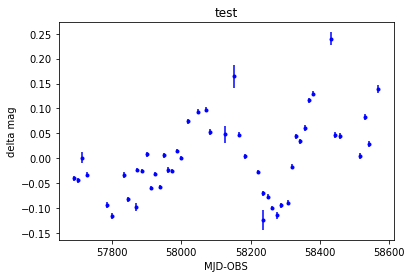

In [5]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [6]:
#J band data
xJ=np.asarray(mjd_obs[mask], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yJerr = np.array(magerr_ref1[mask], dtype=float)

#H band data

#K band data
mask2 = (filt == 'K')
xK=np.asarray(mjd_obs[mask2], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[mask2]-np.median(delta_mag_agn_ref1[mask2]), dtype=float)
yKerr = np.asarray(magerr_ref1[mask2], dtype=float)
print(nJ)

49


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft

XJ_new_temp,muJ_temp,sdJ_temp = np.loadtxt('Jband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XK_new_temp,muK_temp,sdK_temp = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XH_new_temp,muH_temp,sdH_temp = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1,2), unpack=True)

i_low=1
i_high=100

XJ_new=XJ_new_temp[i_low:i_high]
XJ_new=np.reshape(XJ_new,(len(XJ_new),1))
muJ=muJ_temp[i_low:i_high]
sdJ=sdJ_temp[i_low:i_high]

XH_new=XH_new_temp[i_low:i_high]
muH=muH_temp[i_low:i_high]
sdH=sdH_temp[i_low:i_high]

XK_new=XK_new_temp[i_low:i_high]
muK=muK_temp[i_low:i_high]
sdK=sdK_temp[i_low:i_high]

tau=np.linspace(0.1,100.0,99)#time delay array
tau=np.reshape(tau,(1,1,99,1))

print(np.max(tau))

100.0


In [11]:
import theano
import theano.tensor as tt
import theano.tensor.signal.conv

with pm.Model() as convmodel:
    
    #define driving function as Gaussian Process
    #fine way to use g band as first guess of value 
    ℓ = pm.Uniform('ℓ', lower=1.2574, upper=6.0*50.0*np.sqrt(2.0))#
    η = pm.Uniform('η', lower=0.0, upper=1.0)#
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=XJ_new)#use the g band time values here, testval is for diffmag values
    f = f.reshape((1,1,len(XJ_new),1))
    #print(f.shape.ndim)
    #print(f.tag.test_value)
    
    
    #Define priors
    Jsigma_DT=pm.Uniform('Jsigma_DT', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Jsigma_AD=pm.Uniform('Jsigma_AD', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Jm_DT=pm.Uniform('Jm_DT', lower=10.0, upper=300.0)#we expect serveral tens to hundreds of days
    Jm_AD=pm.Uniform('Jm_AD', lower=2.0, upper=100.0)#AD has 3-5 times smaller lags than DT 
    
    Hsigma_DT=pm.Uniform('Hsigma_DT', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Hsigma_AD=pm.Uniform('Hsigma_AD', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Hm_DT=pm.Uniform('Hm_DT', lower=10.0, upper=300.0)#we expect serveral tens to hundreds of days
    Hm_AD=pm.Uniform('Hm_AD', lower=2.0, upper=100.0)#AD has 3-5 times smaller lags than DT
    
    Ksigma_DT=pm.Uniform('Ksigma_DT', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Ksigma_AD=pm.Uniform('Ksigma_AD', lower=tt.log(2.0), upper=tt.log(100.0))#needs a source for scale
    Km_DT=pm.Uniform('Km_DT', lower=10.0, upper=300.0)#we expect serveral tens to hundreds of days
    Km_AD=pm.Uniform('Km_AD', lower=2.0, upper=100.0)#AD has 3-5 times smaller lags than DT
    #medians of the distribution.
    
    #theta_DT=pm.Uniform('theta_DT', lower=0.0, upper=(np.max(tau)))#add later when simple model is staple
    #theta_AD=pm.Uniform('theta_AD', lower=0.0, upper=(np.max(tau)))#add later 
    
    A_T=pm.Uniform('A_T', lower=0.0, upper=1.0)#needs to be restricted between 0 to 1
    
    #Different wavelength for different bands
    Jwav=pm.Uniform('Jwav', lower=tt.log(1000.0), upper=tt.log(1500.0))
    Hwav=pm.Uniform('Hwav', lower=tt.log(1450.0), upper=tt.log(1850.0))
    Kwav=pm.Uniform('Kwav', lower=tt.log(1900.0), upper=tt.log(2400.0))
    
    
    T=pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Uniform('index', lower=0.0, upper=3.0)#sign depends on diffmag definition change to -2 to -1 for final

    #Define constants 
    wav_0 = 500.0#Reference wavelength in nm
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*tt.exp(Jwav)*k*T)
    JBB = (1.0/( (tt.exp(Jwav)**5) * (tt.exp(Jb) - 1.0) ))/BB_max
    Jexp_DT = -((tt.log(tau/Jm_DT))**2/(2*Jsigma_DT**2)) 
    Jfront_DT = A_T/((tau)*Jsigma_DT*np.sqrt(2*np.pi))
    Jlognorm_DT = Jfront_DT*tt.exp(Jexp_DT)
    #lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    #print(lognorm_DT.tag.test_value)
    JPsi_DT = JBB*Jlognorm_DT
    
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*tt.exp(Hwav)*k*T)
    HBB = (1.0/( (tt.exp(Hwav)**5) * (tt.exp(Hb) - 1.0) ))/BB_max
    Hexp_DT = -((tt.log(tau/Hm_DT))**2/(2*Hsigma_DT**2)) 
    Hfront_DT = A_T/((tau)*Hsigma_DT*np.sqrt(2*np.pi))
    Hlognorm_DT = Hfront_DT*tt.exp(Hexp_DT)
    #lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    #print(lognorm_DT.tag.test_value)
    HPsi_DT = HBB*Hlognorm_DT
    
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*tt.exp(Kwav)*k*T)
    KBB = (1.0/( (tt.exp(Kwav)**5) * (tt.exp(Kb) - 1.0) ))/BB_max
    Kexp_DT = -((tt.log(tau/Km_DT))**2/(2*Ksigma_DT**2)) 
    Kfront_DT = A_T/((tau)*Ksigma_DT*np.sqrt(2*np.pi))
    Klognorm_DT = Kfront_DT*tt.exp(Kexp_DT)
    #lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    #print(lognorm_DT.tag.test_value)
    KPsi_DT = KBB*Klognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(tt.exp(Jwav)/wav_0)**(index)    
    Jexp_AD = -((tt.log(tau/Jm_AD)-Jsigma_AD**2)**2/(2*Jsigma_AD**2))
    Jfront_AD = (1.0-A_T)/((tau)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    #lognorm_AD = tt.switch(tt.isnan(lognorm_AD), 0.0, lognorm_AD)
    #print(lognorm_AD.tag.test_value)
    JPsi_AD = Jpowr*Jlognorm_AD
    
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(tt.exp(Hwav)/wav_0)**(index)    
    Hexp_AD = -((tt.log(tau/Hm_AD)-Hsigma_AD**2)**2/(2*Hsigma_AD**2))
    Hfront_AD = (1.0-A_T)/((tau)*Hsigma_AD*np.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    #lognorm_AD = tt.switch(tt.isnan(lognorm_AD), 0.0, lognorm_AD)
    #print(lognorm_AD.tag.test_value)
    HPsi_AD = Hpowr*Hlognorm_AD
    
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(tt.exp(Kwav)/wav_0)**(index)    
    Kexp_AD = -((tt.log(tau/Km_AD)-Ksigma_AD**2)**2/(2*Ksigma_AD**2))
    Kfront_AD = (1.0-A_T)/((tau)*Ksigma_AD*np.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    #lognorm_AD = tt.switch(tt.isnan(lognorm_AD), 0.0, lognorm_AD)
    #print(lognorm_AD.tag.test_value)
    KPsi_AD = Kpowr*Klognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    
    #The convolutions
    
    Jconvol=theano.tensor.nnet.conv2d(f,Jtransfer,border_mode='half')#filter needs to be odd so tau is odd
    Hconvol=theano.tensor.nnet.conv2d(f,Htransfer,border_mode='half')
    Kconvol=theano.tensor.nnet.conv2d(f,Ktransfer,border_mode='half')
    #print(convol[0,0,:,0].tag.test_value)
    #print(len(convol[0,0,:,0].tag.test_value))
    #Define likelihoods
    Jlikelihood = pm.Normal('muJ', mu=Jconvol[0,0,:,0], sigma=sdJ, observed=muJ)
    Hlikelihood = pm.Normal('muH', mu=Hconvol[0,0,:,0], sigma=sdH, observed=muH)
    Klikelihood = pm.Normal('muK', mu=Kconvol[0,0,:,0], sigma=sdK, observed=muK)
    #the shape of mu and observed needs to be the same 
    
    tracetransfer = pm.sample(2000, tune=1000, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Malte\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

In [22]:
names=['index', 'K_0', 'T', 'Kwav', 'Hwav', 'Jwav', 'A_T', 'Km_AD', 'Km_DT', 'Ksigma_AD', 'Ksigma_DT', 'Hm_AD', 'Hm_DT', 'Hsigma_AD', 'Hsigma_DT', 'Jm_AD', 'Jm_DT', 'Jsigma_AD', 'Jsigma_DT', 'η', 'ℓ']
pm.summary(tracetransfer, names)

C:\Users\Malte\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
index,2.189559,0.679223,0.049145,0.634325,2.999390,4.324163,1.437261
K_0,4.776811,2.783583,0.132842,0.528289,9.591203,24.832634,1.085477
T,1460.600105,85.759941,3.198668,1289.733449,1626.001047,347.172249,1.026696
Kwav,7.612597,0.056324,0.002796,7.549627,7.735891,11.200683,1.133755
Hwav,7.485908,0.037717,0.001809,7.406791,7.522936,12.784888,1.117766
Jwav,7.045687,0.102734,0.007664,6.909246,7.270445,3.585605,1.551939
A_T,0.827680,0.123038,0.005697,0.607486,0.983686,325.434287,1.021619
Km_AD,90.977089,9.794585,0.670498,78.552348,99.994689,109.024320,1.009376
Km_DT,157.985972,98.843303,8.523367,10.867258,289.208709,2.665735,2.087880
Ksigma_AD,0.914201,0.329254,0.024423,0.693718,1.738191,15.397247,1.161199


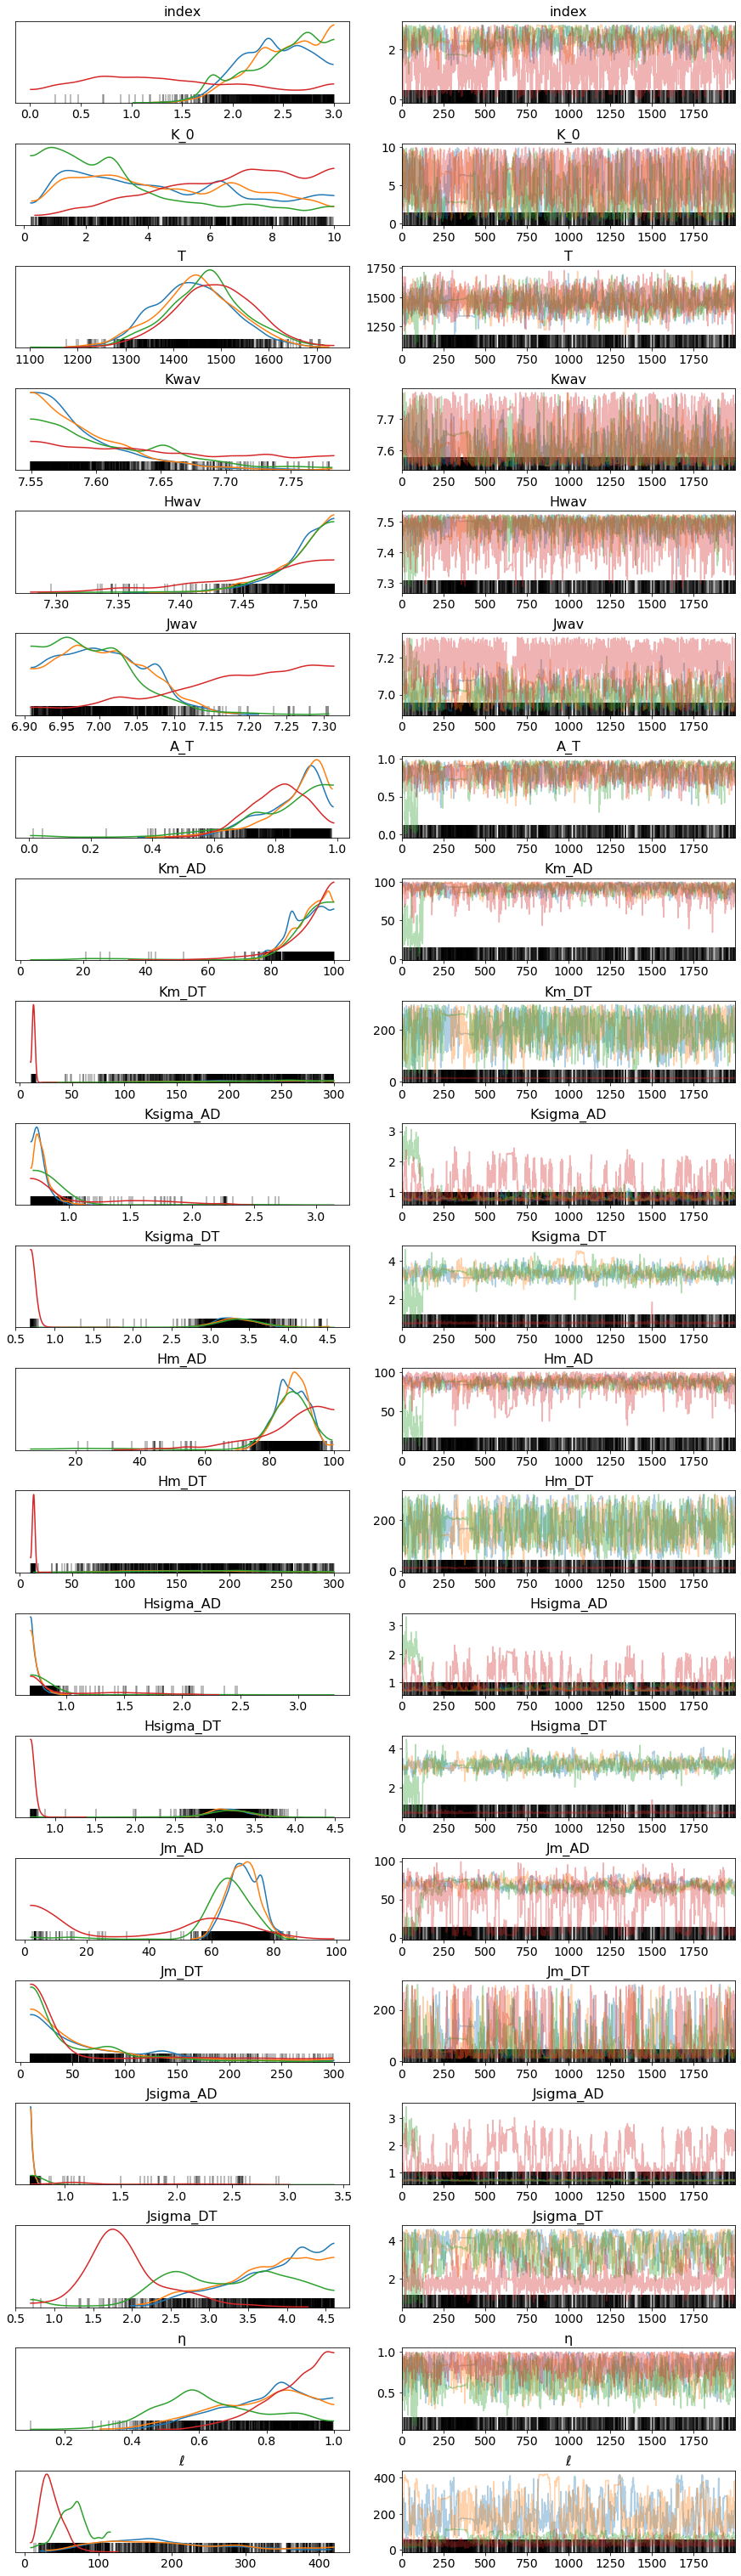

In [25]:
pm.traceplot(tracetransfer, var_names=names);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028E2CDB7C48>,
      dtype=object)

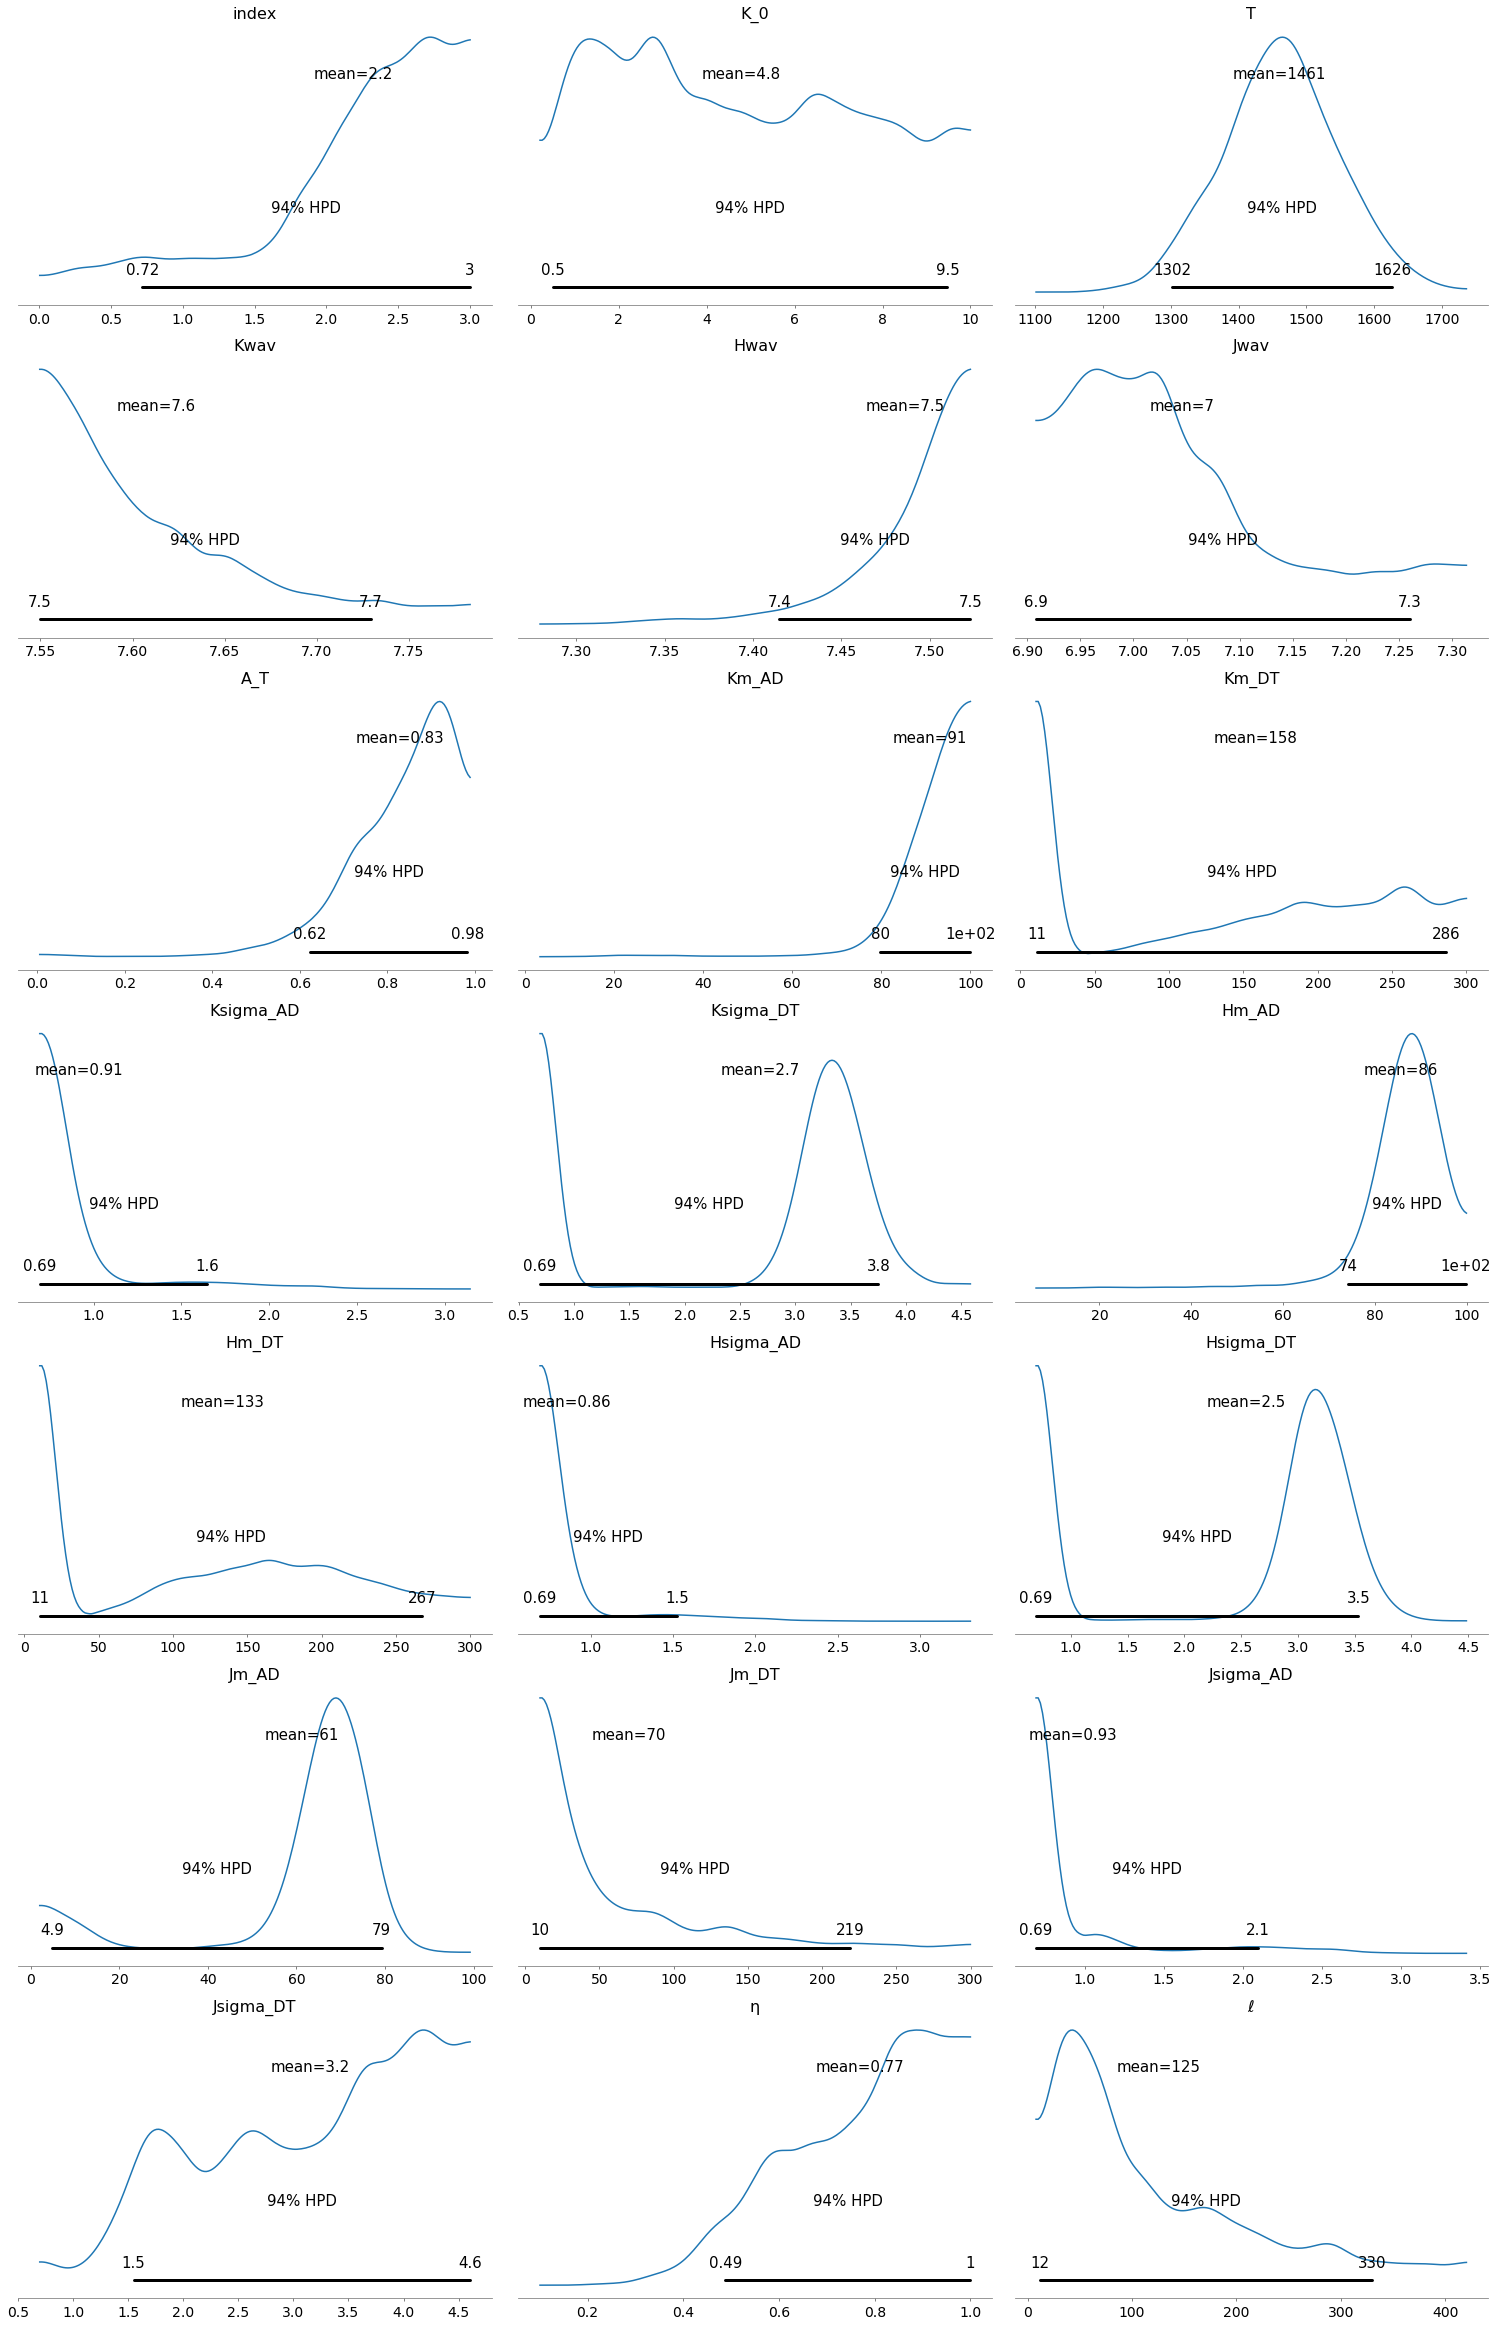

In [24]:
pm.plot_posterior(tracetransfer,names)